In [1]:
import torch
import os.path
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.data import Subset, random_split, DataLoader, Dataset, BatchSampler, RandomSampler
from torchvision import transforms
from torchvision.transforms import functional as F
import sys
import colorsys
from typing import List

In [2]:
def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# Statistics

In [250]:
# export_path = "/local/scratch/motterbe/save_runs/2023_09_15_155018/"
export_path = "C:/Users/motterbe/save-runs/2023_09_28_235554/"
global_epochs = 400
num_clients = 10

In [267]:
def load_if_exists(path):
    total_path = f"{export_path}/{path}"
    if os.path.exists(total_path):
        return torch.load(total_path, map_location="cpu")
    else:
        print("Not Exist!")
        return None

def load_by_layer(layer_count: int):
    layers = []
    for layer_num in range(0, layer_count):
        round_layers = []
        for round_num in range(0, global_epochs):
            # non_null_clients = filter(lambda r: r is not None, variates[round_num])
            client_layers = []
            for client in range(0, 10):
                client_round = load_if_exists(f"control_variates_c{client}_r{round_num}.pt")
                client_layers.append(client_round[layer_num])
            client_arr = np.asarray(client_layers) 
            round_layers.append(client_arr)
        round_arr = np.asarray(round_layers)
        layers.append(round_arr)
    return layers

def load_and_group(layer_count: int):
    group_indices = np.ma.arange(0,num_clients).reshape((num_clients//2, 2))
    round_means = []
    specific_round_difs = []
    generic_round_difs = []
    for round in range(0, global_epochs):
        groups_means = []
        specific_group_difs = []
        generic_group_difs = []
        variates = zip(*[load_if_exists(f"control_variates_c{client}_r{round}.pt") for client in range(0,num_clients)])
        layer_variates = [np.asarray(layer) for layer in variates]
        print(f"Round {round}")

        for group_num, indices in enumerate(group_indices):

            layer_means = []
            specific_layer_difs = []
            generic_layer_difs = []
            # print(f"Going for group {group_num}")
            for index, layer in enumerate(layer_variates):
                inner_group_means = layer[group_indices].mean(axis=1)

                sumrange = tuple(range(1,inner_group_means.ndim))
                dif_to_other_groups = np.sqrt(((inner_group_means-inner_group_means[group_num])**2).sum(axis=sumrange))
                generic_layer_difs.append(dif_to_other_groups)
                # print(dif_to_other_groups.shape, dif_to_other_groups, inner_group_means.shape)
                # print(layer.shape)
                inner_mean = inner_group_means[group_num]
                # inner_mean = layer[indices].mean(axis=0)
                # print(layer[indices].shape)
                inner_dif = np.sqrt(((layer[indices][0]-layer[indices][1])**2).sum())
                group_indices[group_num] = np.ma.masked
                # print(layer[indices].shape, layer[group_indices.flatten().compressed()].shape, group_indices.flatten().compressed())
                outer_mean = layer[group_indices.flatten().compressed()].mean(axis=0)
                # print(inner_group_means.shape, layer[indices].shape, inner_mean.shape)
                inter_difs = np.sqrt(((inner_mean-outer_mean)**2).sum())
                group_indices.mask[group_num] = False
                # print(inner_mean.shape, outer_mean.shape)
                # layer_means.append(np.stack((inner_mean, outer_mean)))
                specific_layer_difs.append(np.asarray((inner_dif, inter_difs)))
            
            groups_means.append(layer_means)
            specific_group_difs.append(specific_layer_difs)
            generic_group_difs.append(generic_layer_difs)

        round_means.append(groups_means)
        specific_round_difs.append(specific_group_difs)
        generic_round_difs.append(generic_group_difs)

    ret = (round_means, specific_round_difs, generic_round_difs)
    torch.save(ret, f"{export_path}/cv_difs.pt")

    return ret

In [257]:
round_means, specific_rounds, generic_round_difs = torch.load(f"{export_path}/cv_difs.pt")
b = np.asarray(generic_round_difs)

In [266]:
np.asarray(generic_round_difs).shape

(400, 400, 5, 62, 2)

In [268]:
stats = load_pickle(f"{export_path}/stats_{global_epochs-1}.pkl")
means, difs, specific_difs = load_and_group(62)

Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Round 11
Round 12
Round 13
Round 14
Round 15
Round 16
Round 17
Round 18
Round 19
Round 20
Round 21
Round 22
Round 23
Round 24
Round 25
Round 26
Round 27
Round 28
Round 29
Round 30
Round 31
Round 32
Round 33
Round 34
Round 35
Round 36
Round 37
Round 38
Round 39
Round 40
Round 41
Round 42
Round 43
Round 44
Round 45
Round 46
Round 47
Round 48
Round 49
Round 50
Round 51
Round 52
Round 53
Round 54
Round 55
Round 56
Round 57
Round 58
Round 59
Round 60
Round 61
Round 62
Round 63
Round 64
Round 65
Round 66
Round 67
Round 68
Round 69
Round 70
Round 71
Round 72
Round 73
Round 74
Round 75
Round 76
Round 77
Round 78
Round 79
Round 80
Round 81
Round 82
Round 83
Round 84
Round 85
Round 86
Round 87
Round 88
Round 89
Round 90
Round 91
Round 92
Round 93
Round 94
Round 95
Round 96
Round 97
Round 98
Round 99
Round 100
Round 101
Round 102
Round 103
Round 104
Round 105
Round 106
Round 107
Round 108
Round 109
Round 110


In [214]:
loss_before = np.asarray([[client["loss_before"] for client in round_] for round_ in stats])
loss_after = np.asarray([[client["loss_after"] for client in round_] for round_ in stats])
train_acc_before = np.asarray([[client["train_acc_before"] for client in round_] for round_ in stats])
acc_before = np.asarray([[client["correct"]/client["size"] for client in round_] for round_ in stats])
train_acc_after = np.asarray([[client["train_acc_after"] for client in round_] for round_ in stats])
acc_after = np.asarray([[client["correct_after"]/client["size"] for client in round_] for round_ in stats])
index_array = np.arange(0, global_epochs, 1)

indexed_loss_before = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(loss_before.T)])
indexed_loss_after = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(loss_after.T)])
indexed_acc_before = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(acc_before.T)])
indexed_train_acc_before = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(train_acc_before.T)])
indexed_acc_after = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(acc_after.T)])
indexed_train_acc_after = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index,client in enumerate(train_acc_after.T)])



In [264]:
len(difs[0])

5

In [215]:
index_array = np.arange(0, global_epochs, 1)
broadcast_index = np.broadcast_to(index_array, (num_clients//2,1,global_epochs))

group_indices = np.ma.arange(0,num_clients).reshape((num_clients//2, 2))
group_train_acc_before = np.take(train_acc_before, group_indices, axis=1).mean(axis=2).T
group_acc_before = np.take(acc_before, group_indices, axis=1).mean(axis=2).T

mapped_arr = np.asarray(difs).transpose((1,3,2,0)).mean(axis=2)
indexed_stats = np.concatenate((mapped_arr, broadcast_index), axis=1)

indexed_inner_difs = indexed_stats[:,(2,0)]
indexed_inter_difs = indexed_stats[:,(2,1)]
indexed_group_train_acc_before = np.stack((broadcast_index[:,0,:], group_train_acc_before, ), axis=1)
indexed_group_acc_before = np.stack((broadcast_index[:,0,:], group_acc_before), axis=1)


In [8]:
def plot_stat_by_epoch(stat, ax=None, line=None, counterstat = None, counternames=["Control Variate"], stat_max_x = None, counter_max_y = None, counter_colors: List = None, stat_colors: List = None):
    if ax is None or line is None:
        line, ax = plt.subplots()
    
    labels= ["Global Accuracy", "Local Accuracy"]
    ax.set(xlabel="Epoch", ylabel="Accuracy")
    if stat_max_x is not None:
        ax.set_ylim((0,stat_max_x))
    for stat_id, current_stat in enumerate(stat):
        color = "blue"
        if stat_colors is not None:
            color = stat_colors[stat_id]
        ax.plot(current_stat[0], current_stat[1], label=labels[stat_id], color=color)

    ax.legend(loc="lower right")
    ax2 = ax.twinx()
    ax2.set(ylabel="Control Variate Difference")

    # ax2.invert_yaxis()
    if counter_max_y is not None:
        ax2.set_ylim((counter_max_y,0))
    if counterstat is not None:
        for stat_id, current_stat in enumerate(counterstat):
            color = "r"
            if counter_colors is not None:
                color = counter_colors[stat_id]
            ax2.plot(current_stat[0], current_stat[1], label=f"{counternames[stat_id]}", color=color)
        ax2.legend(loc="upper left")

def plot_multiple_stats_by_epoch(stats, counterstats, counter_colors: List = None, stat_colors: List = None):
    plot_count = len(stats)
    left_count = math.ceil(plot_count/2)
    # right_count = math.floor(plot_count/2)

    (lines, axes) = plt.subplots(left_count, 2, figsize=(20,10))

    print(stats.shape)
    stat_max = stats[:, :, 0].max()
    counter_max= counterstats[:, :, 1].max()

    for plot_index in range(0, plot_count):
        col = plot_index%2
        row = math.floor(plot_index/2)
        

        plot_stat_by_epoch(
            stat=stats[plot_index],
            counterstat=counterstats[plot_index], 
            ax=axes[row, col], 
            line=lines, 
            counternames=["Inner CV Dif", "Inter CV Dif"], 
            counter_max_y=counter_max, 
            stat_max_x=1, 
            counter_colors=counter_colors, 
            stat_colors=stat_colors)
        axes[row, col].set_title(f"Group {plot_index}")
    
    for ax in axes.flat:
        ax.label_outer()
    
    plt.show()

def plot_grouped_stats(global_acc: np.ndarray, local_acc: np.ndarray, inner_cv_dif: np.ndarray, inter_cv_dif: np.ndarray):
    plot_multiple_stats_by_epoch(
        stats=np.stack((indexed_group_acc_before, indexed_group_train_acc_before), axis=1),
        counterstats=np.stack((indexed_inner_difs, indexed_inter_difs), axis=1),
        stat_colors=["tab:blue", "tab:green"],
        counter_colors=["tab:orange", "tab:red"]
    )

In [166]:
def trySum(a, b):
    if a is None or b is None:
        return None
    else:
        return ((a-b)**2).sum()

def tryMean(a,b):
    if a is None or b is None:
        return None
    else:
        comp = torch.stack([((global_layer-local_layer)**2).sum().sqrt() for (global_layer,local_layer) in zip(a, b)]).mean()
        return comp

def cv_mean(clients: List[List[torch.Tensor]]):
    non_null = list(filter(lambda x: x is not None, clients))
    layers = []
    for layer in range(0, len(non_null[0])):
        layers.append(np.stack([non_null[client_num][layer] for client_num in range(0, len(non_null))]))

    layer_mean = [layer.mean(dim=0) for layer in layers]
    return layer_mean



inter_difs = [{f"{index1}_{index2}": tryMean(v1,v2) for (index2, v2) in enumerate(round_variates) for (index1, v1) in enumerate(round_variates) if index1 > index2}  for round_variates in variates]
local_inter_difs = np.asarray([[[tryMean(v1,v2) for (index2, v2) in enumerate(round_variates) if index1 != index2] for (index1, v1) in enumerate(round_variates)]  for round_variates in variates])
diffs = [[tryMean(g, c_l) for c_l in c_ls] for (g, c_ls) in zip(c_g, variates)]
offset_diffs = [[tryMean(c_g[i], c_l) for c_l in variates[i+1]] for i in range(0,global_epochs-1)]

indexed_cv_global_diff = np.asarray([np.stack((index_array[np.isfinite(client)], client[np.isfinite(client)])) for index, client in enumerate(np.asarray(diffs).T)])
indexed_cv_inter_diffs = np.asarray([np.stack((index_array[np.isfinite(client_diffs)], client_diffs[np.isfinite(client_diffs)])) for client_index, client_diffs in enumerate(np.asarray(local_inter_difs).mean(2).transpose(1,0))])

NameError: name 'variates' is not defined

In [110]:
del offset_diffs

In [8]:
inter_dif_per_round = [torch.stack([clientDif for (diffName, clientDif) in round.items() if clientDif is not None]).mean().item() for round in inter_difs]




diffPerRound = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).mean().item() for dif in diffs]
max_dif = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).max().item() for dif in diffs]
offset_diff_mean = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).mean().item() for dif in offset_diffs]
offset_max_dif = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).max().item() for dif in offset_diffs]

(5, 2, 2, 399)


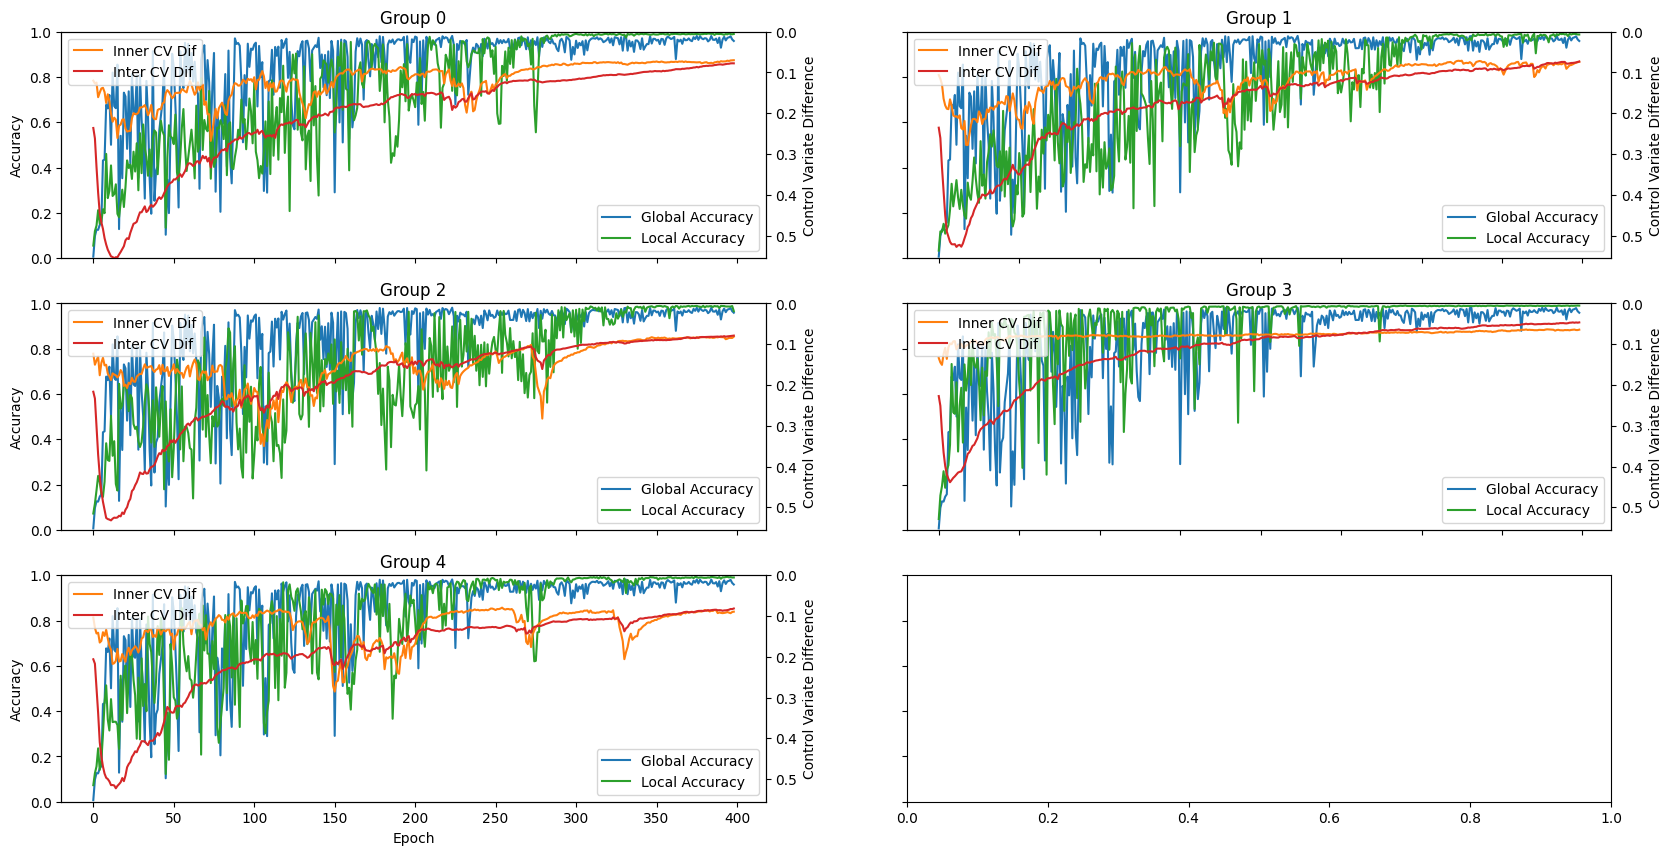

In [183]:
# plot_multiple_stats_by_epoch(np.stack((indexed_group_acc_before, indexed_group_train_acc_before), axis=1), np.stack((indexed_inner_difs, indexed_inter_difs), axis=1))
plot_grouped_stats(indexed_group_acc_before, indexed_group_train_acc_before, indexed_inner_difs, indexed_inter_difs)

#2023_09_20_123215


In [14]:
indexed_acc_before.shape

(10, 2, 300)

(5, 2, 2, 399)


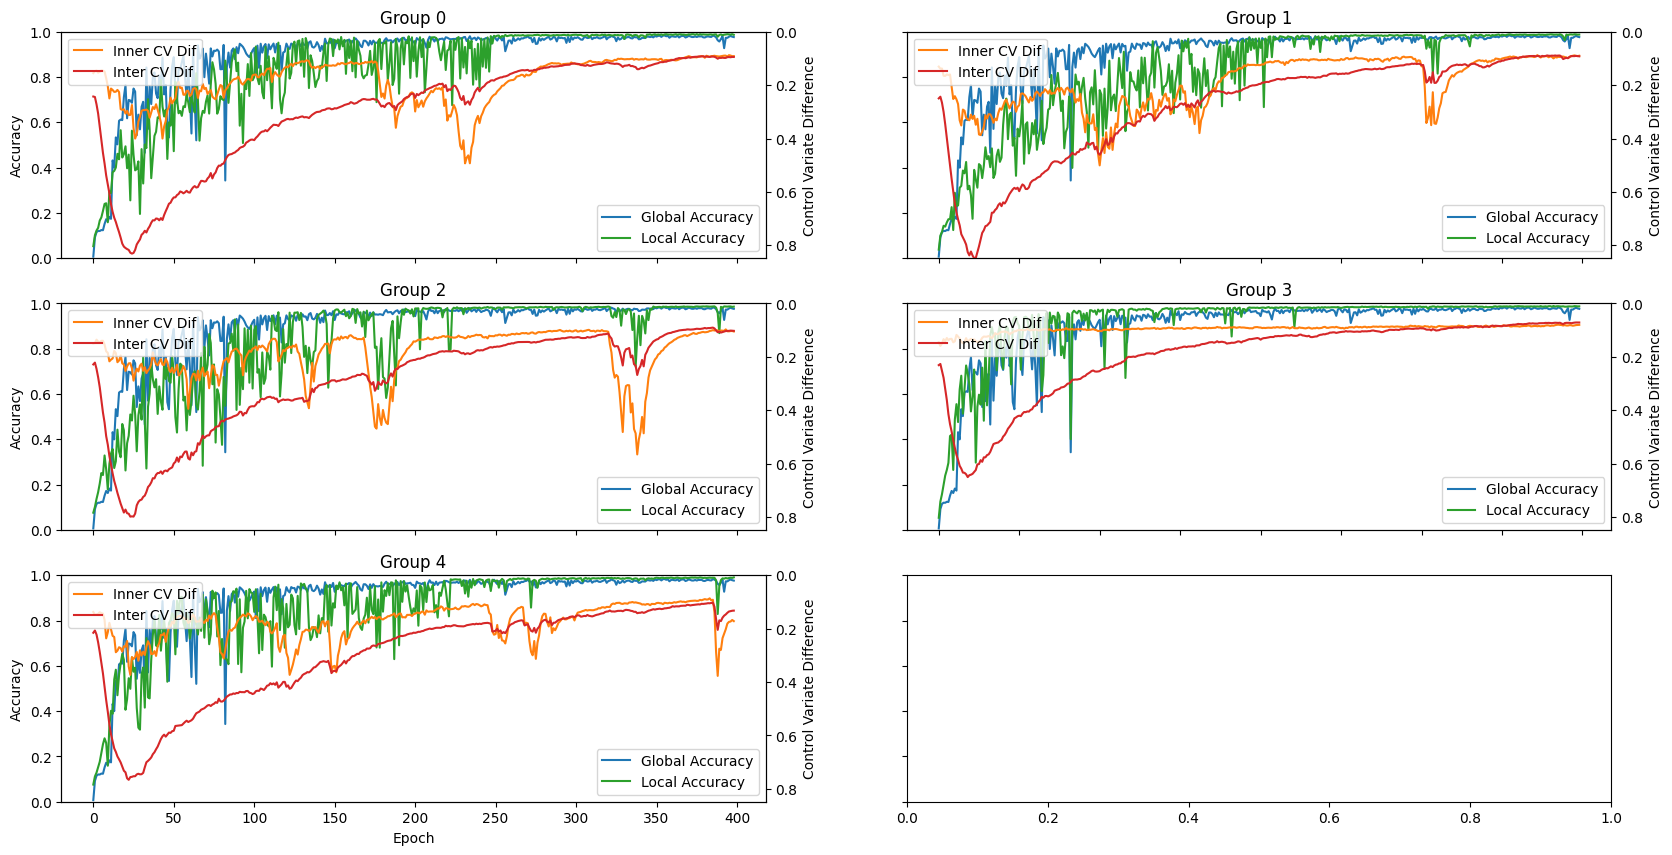

In [196]:
plot_grouped_stats(indexed_group_acc_before, indexed_group_train_acc_before, indexed_inner_difs, indexed_inter_difs)
#2023_09_23_1250


(5, 2, 2, 399)


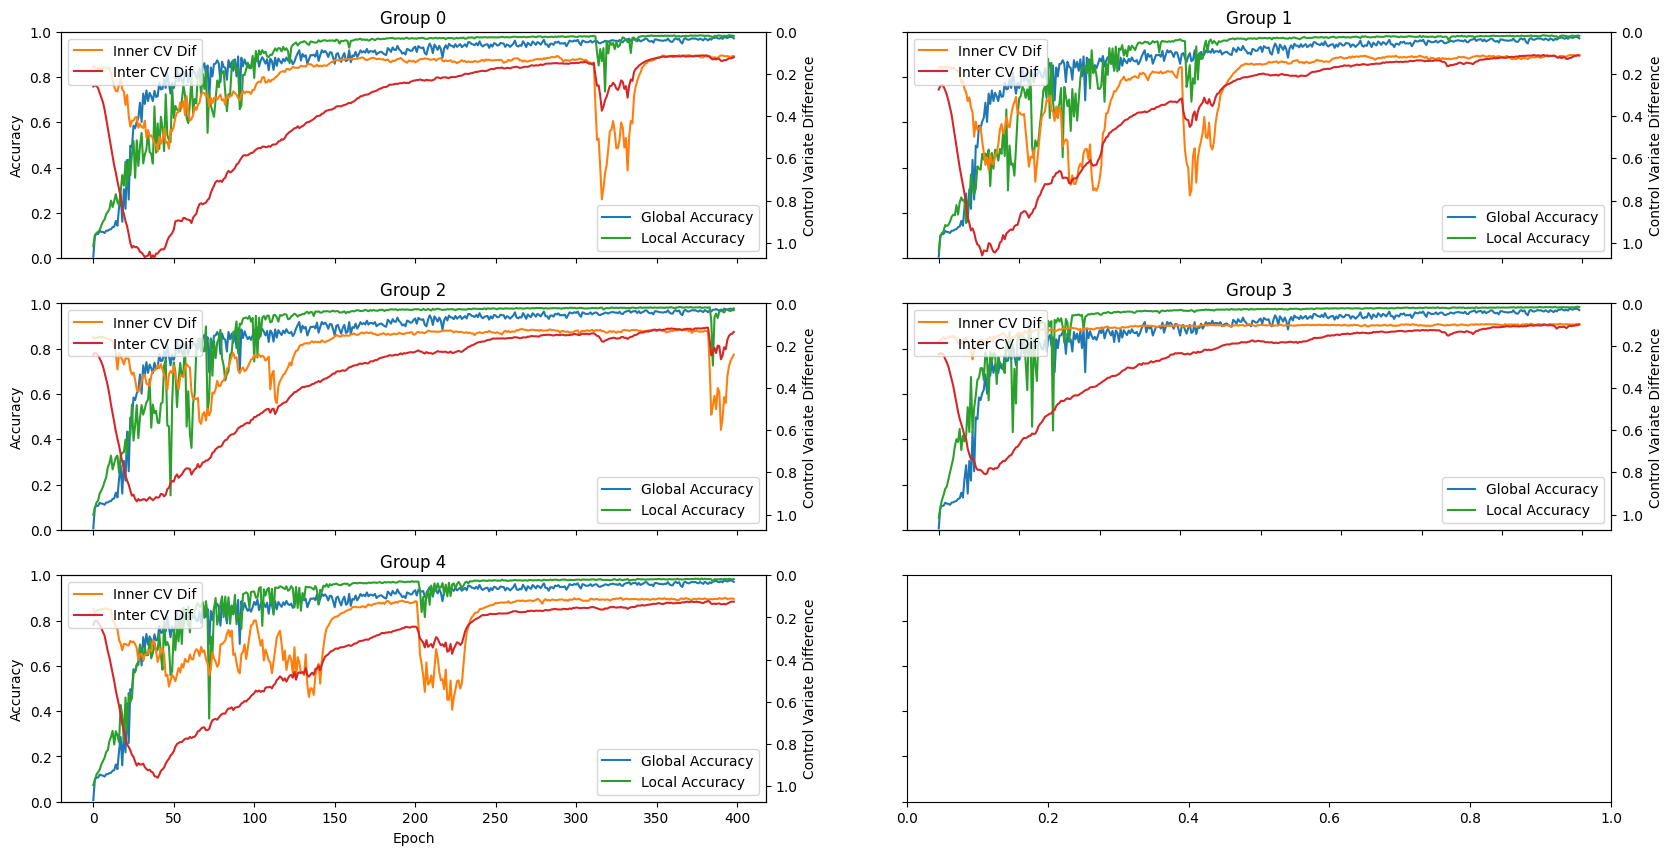

In [12]:
plot_grouped_stats(indexed_group_acc_before, indexed_group_train_acc_before, indexed_inner_difs, indexed_inter_difs)
#2023_09_24_1258


(5, 2, 2, 400)


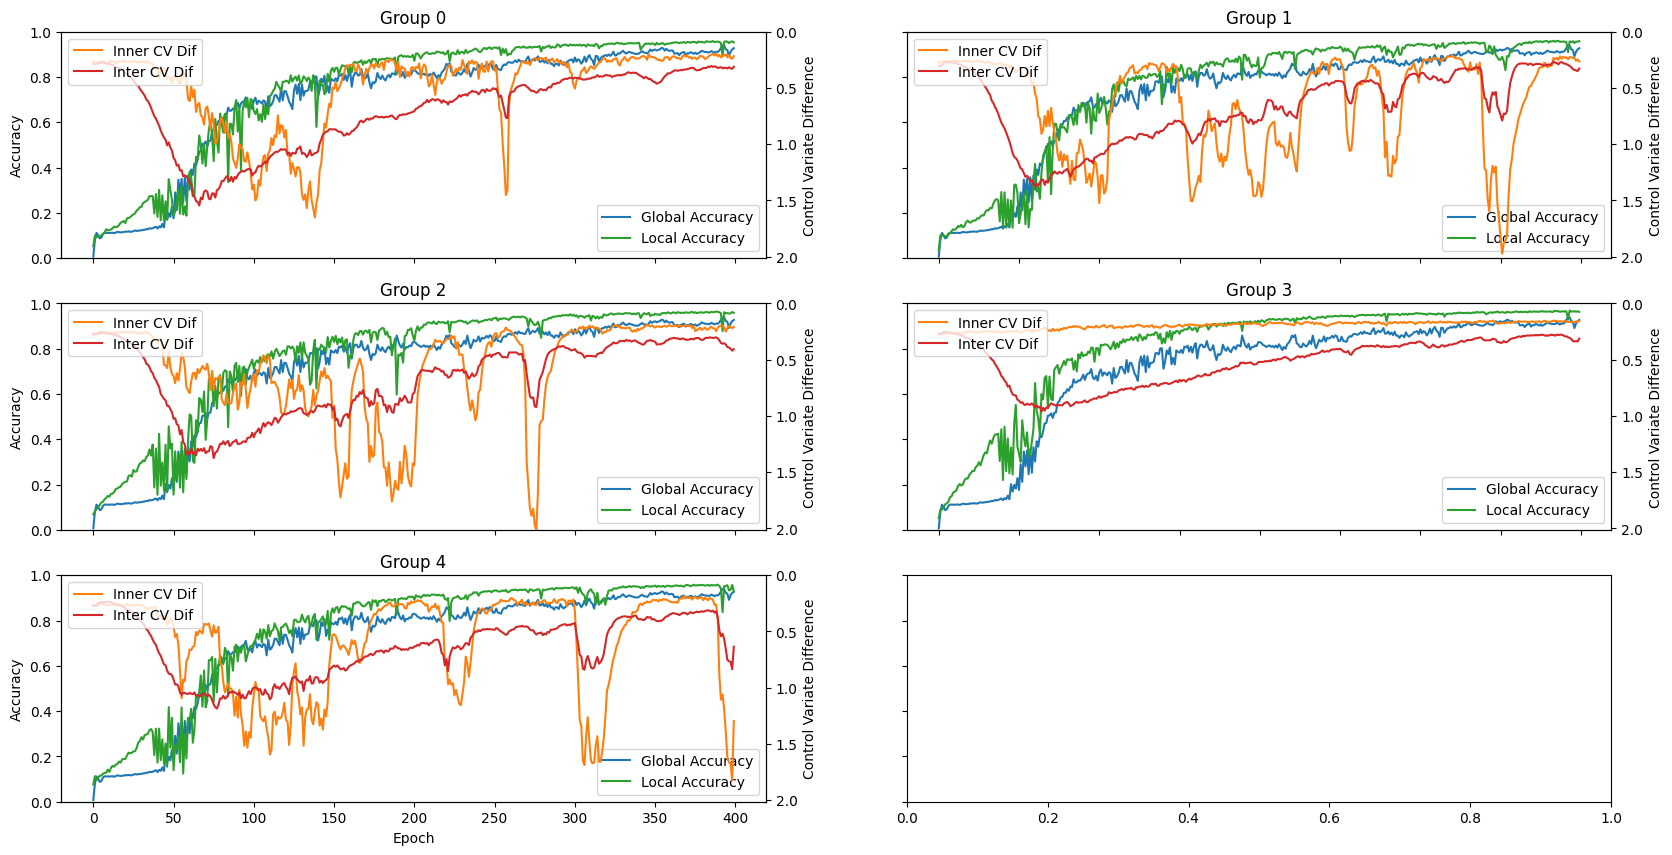

In [29]:
plot_grouped_stats(indexed_group_acc_before, indexed_group_train_acc_before, indexed_inner_difs, indexed_inter_difs)
#2023_09_26
#Only 1 local epoch

(5, 2, 2, 400)


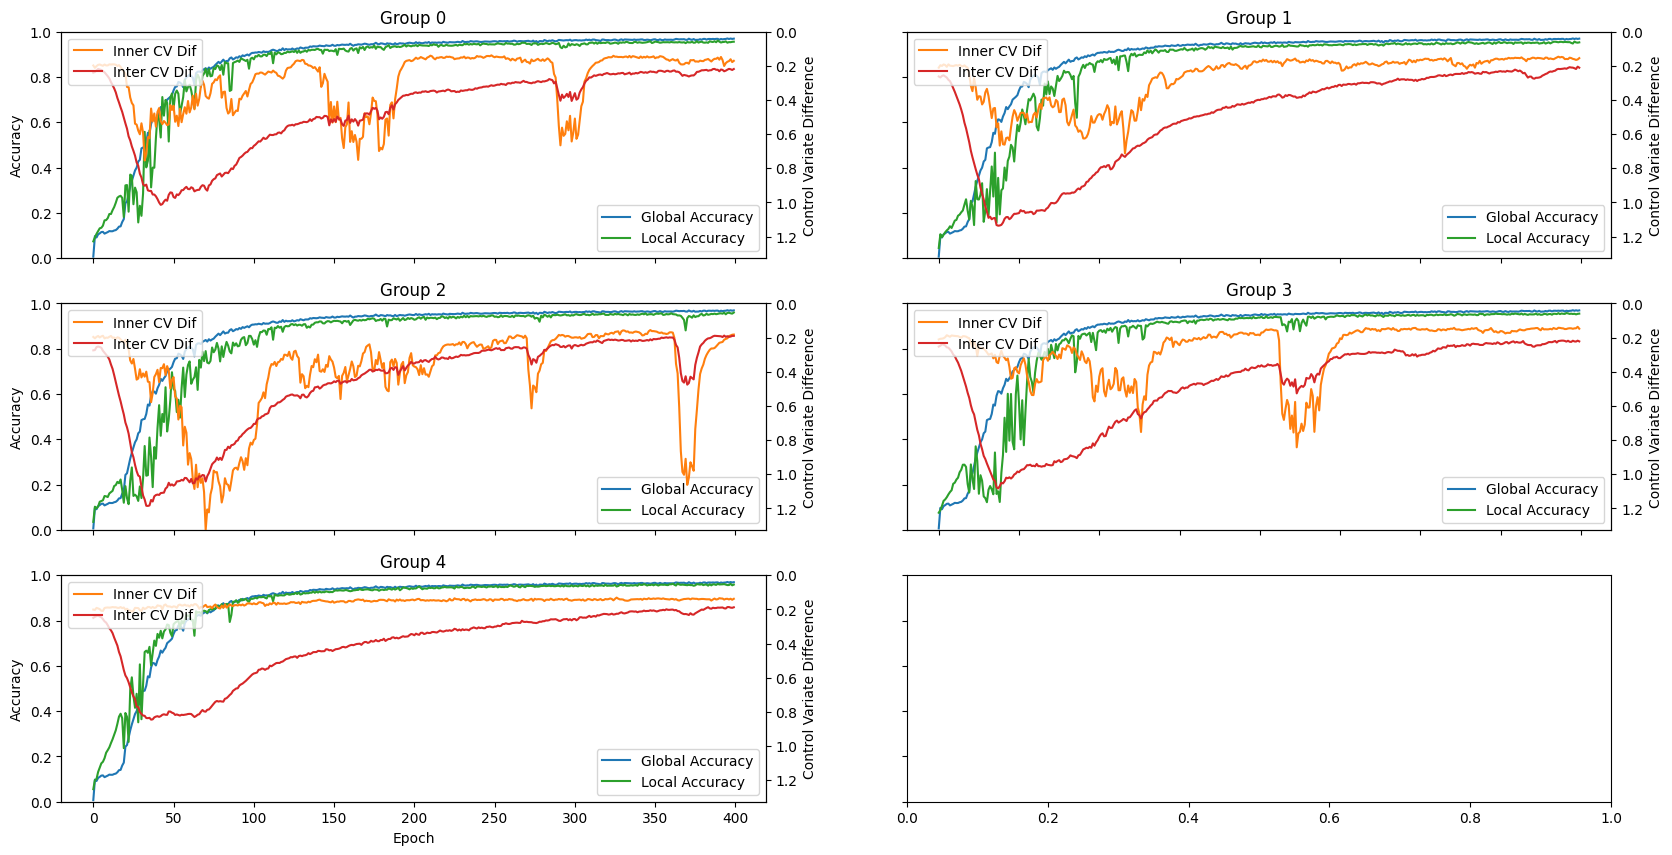

In [177]:
plot_grouped_stats(indexed_group_acc_before, indexed_group_train_acc_before, indexed_inner_difs, indexed_inter_difs)

(5, 2, 2, 400)


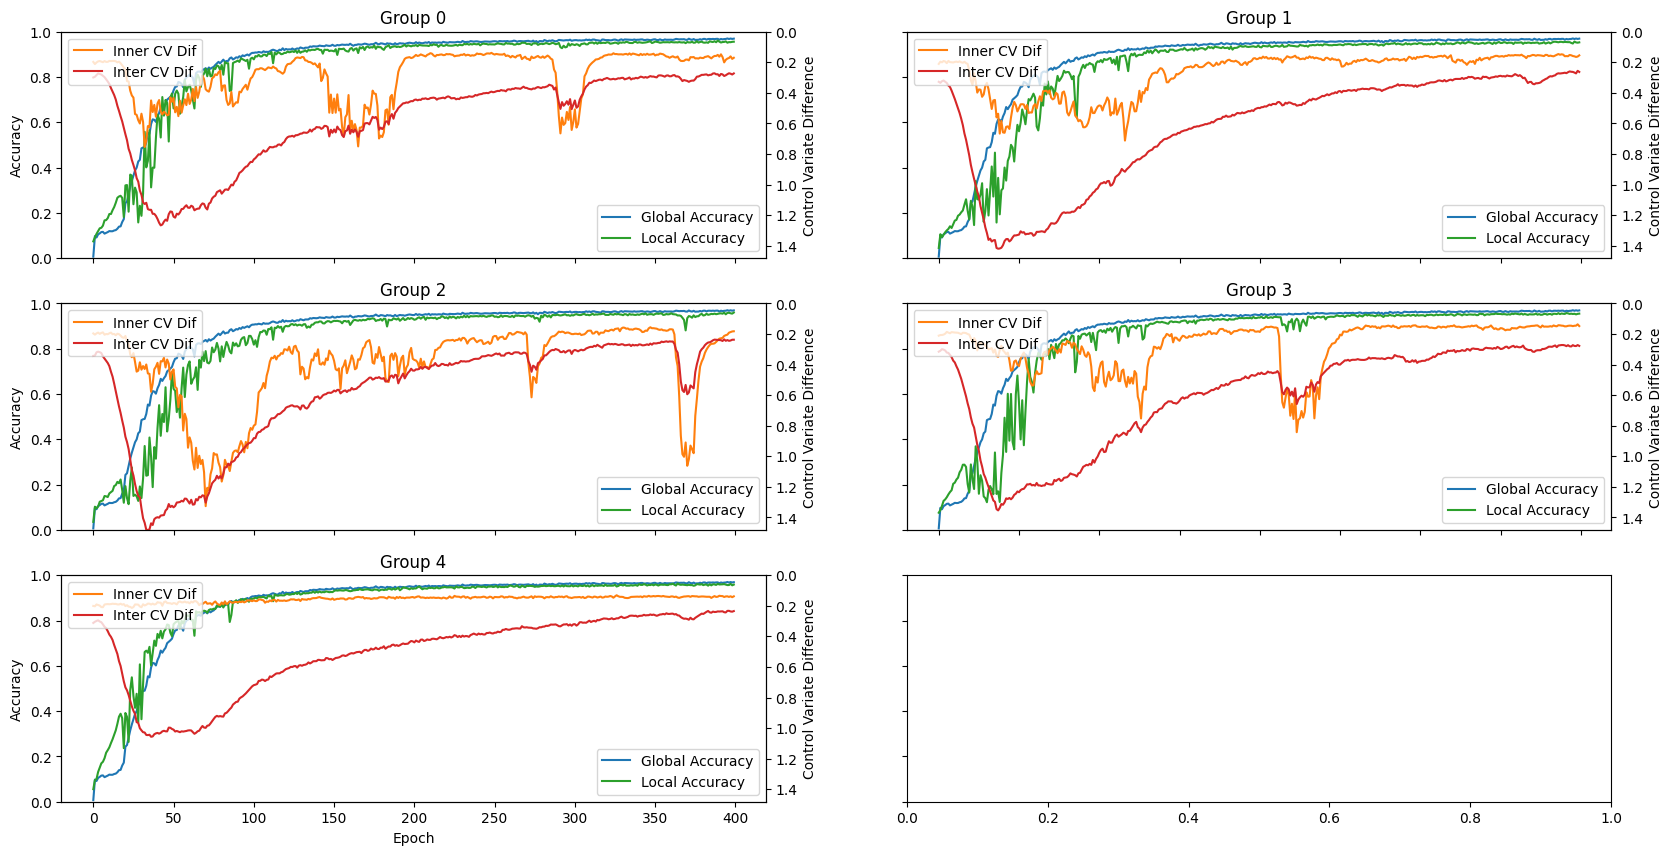

In [216]:
plot_grouped_stats(indexed_group_acc_before, indexed_group_train_acc_before, indexed_inner_difs, indexed_inter_difs)

# Augmentations

In [4]:
# del sys.modules["utils.dataset.MNISTDataset"]
# del sys.modules["utils.dataset"]
# del sys.modules["utils"]
sys.path.append("../data")
# del colorcycle, CyclicDeform
# from utils.augmentations import colorcycle, CyclicDeform

In [5]:
from utils.dataset import CIFARDataset, MNISTDataset
from utils.augmentations.MultiConcatDataset import MultiConcatDataset
from utils.CudaDataset import CudaDataset

pickle_path = "../data/emnist/pickles/0.pkl"
t = load_pickle(pickle_path)

In [6]:
class AugSet(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

import bisect
import warnings
import torch
from typing import (
    Iterable,
    List,
    TypeVar,
)

T_co = TypeVar('T_co', covariant=True)

from torch.utils.data import Dataset, IterableDataset


import bisect
import warnings
from typing import (
    Iterable,
    List,
    TypeVar,
)

T_co = TypeVar('T_co', covariant=True)

from torch.utils.data import Dataset, IterableDataset


class DultiConcatDataset(Dataset[T_co]):
    r"""Dataset as a concatenation of multiple datasets.

    This class is useful to assemble different existing datasets.

    Args:
        datasets (sequence): List of datasets to be concatenated
    """
    datasets: List[Dataset[T_co]]
    cumulative_sizes: List[int]

    @staticmethod
    def cumsum(sequence):
        r, s = [], 0
        for e in sequence:
            l = len(e)
            r.append(l + s)
            s += l
        return r

    def __init__(self, datasets: Iterable[Dataset], device: torch.cuda.Device) -> None:
        super().__init__()
        self.device = device
        self.datasets = list(datasets)
        assert len(self.datasets) > 0, 'datasets should not be an empty iterable'  # type: ignore[arg-type]
        for d in self.datasets:
            assert not isinstance(d, IterableDataset), "ConcatDataset does not support IterableDataset"
        self.cumulative_sizes = self.cumsum(self.datasets)
        self.t_cumulative_sizes = torch.as_tensor(self.cumulative_sizes).to(device)

    def __len__(self):
        return self.cumulative_sizes[-1]

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            start = idx.start
            stop = idx.stop
            step = idx.step
            if start is None:
                start = 0
            if stop is None:
                stop = self.__len__()
            if step is None:
                step = 1

            idx = range(start, stop, step)

        t_idx = torch.as_tensor(idx).to(self.device)
        dataset_idx = torch.searchsorted(self.t_cumulative_sizes, t_idx, side="right")
        sample_idx = t_idx.clone()
        sample_idx[dataset_idx != 0] = t_idx[dataset_idx != 0] - self.t_cumulative_sizes[dataset_idx[dataset_idx != 0] -1]
        d2_indices = torch.stack((dataset_idx, sample_idx, t_idx, torch.arange(0, len(idx)).to(self.device)))

        mapped_sample_indices = []
        targets = []
        inputs = []
        # print(f"Retrieving samples from datasets with ids {torch.unique(dataset_idx)}")
        for dataset_id in torch.unique(dataset_idx):
            dataset_samples = d2_indices[0]==dataset_id
            sample_indices = d2_indices[:,dataset_samples][1]

            selected_data = self.datasets[dataset_id][sample_indices.tolist()]
            selected_ids = d2_indices[:,dataset_samples]

            mapped_sample_indices.append(selected_ids)
            inputs.append(selected_data[0])
            targets.append(selected_data[1])

        tensor_targets = torch.concat(targets, dim=0)
        tensor_inputs = torch.concat(inputs, dim=0)
        tensor_indices_mapping = torch.concat(mapped_sample_indices, dim=1)
        test_index = tensor_indices_mapping[3].argsort()
        sorting_index = test_index
        sorted_indices = tensor_indices_mapping[:,sorting_index]

        tensor_targets = tensor_targets[sorting_index]
        tensor_inputs = tensor_inputs[sorting_index]

        return (tensor_inputs, tensor_targets)

    @property
    def cummulative_sizes(self):
        warnings.warn("cummulative_sizes attribute is renamed to "
                      "cumulative_sizes", DeprecationWarning, stacklevel=2)
        return self.cumulative_sizes


In [70]:
from torchvision.transforms.functional import elastic_transform


class CyclicDeform:
    def __init__(self, epoch: int, cycle: int, img_size: tuple[int], device: torch.device, stretch_intensity=3):
        self.epoch = epoch
        assert isinstance(epoch, int)
        assert isinstance(cycle, int)
        assert isinstance(img_size, tuple)
        
        angle = (epoch*360/cycle)%360
        x = math.sin(math.radians(angle))
        y = math.cos(math.radians(angle))
        
        displacement_grid = np.mgrid[-1:1:img_size[0]*1j, -1:1:img_size[1]*1j]
        
        displacement_weights = np.abs(x*-displacement_grid[0]-(-displacement_grid[1])*(y))/np.linalg.norm((x,y))
        displacement_weights -= 1
        displacement_weights = np.abs(displacement_weights)
        displacement_weights /= displacement_weights.max()
        displacement_weights = np.around(displacement_weights, 2)
        # z_displacement = np.full((control_points[0],control_points[1]), 1)
        # self.displacement = torch.from_numpy(np.asarray((z_displacement, y*displacement_weights, x*displacement_weights))* stretch_intensity)
        self.displacement = torch.from_numpy(np.asarray((x*displacement_weights, y*displacement_weights))* stretch_intensity)
        self.displacement = torch.unsqueeze(self.displacement.permute((1,2,0)), 0).to(device)
        # self.displacement = torch.unsqueeze(self.displacement, 1)
        # print(self.displacement.shape)

    def __call__(self, sample: torch.tensor):
        # image = sample.permute(1, 2, 0).numpy()[:,:,0]
        # image = sample[0]
        # print(image.shape)
        # normalized = (image - torch.min(image))/np.ptp(image)
        # deformed = deform_grid(image, self.displacement)
        deformed = elastic_transform(sample, self.displacement)
        # deformed = elasticdeform.deform_grid(image.numpy(), self.displacement.numpy())
        return deformed
    
class ExpandToRGB:
    def __init__(self):
        a = 1
        # print(self.displacement.shape)

    def __call__(self, sample: torch.tensor):
        norm = (sample - torch.min(sample))/torch.max(sample)
        ret = norm.repeat_interleave(3, dim=1)
        # deformed = elasticdeform.deform_grid(image.numpy(), self.displacement.numpy())
        return ret


In [7]:
class CycleColor:
    def __init__(self, epoch: int, cycle: int, background_tolerance: int, device: torch.device, generation_range: int, style_count: int):
        self.epoch = epoch
        self.background_hue = ((self.epoch+10)*360/cycle)%360
        self.digit_hue = ((self.epoch+30)*360/cycle)%360

        bg_saturation, gv_val, digit_saturation, digit_val = torch.FloatTensor(4, style_count).uniform_(0.2, 1)
        

        self.background_pool = torch.as_tensor([colorsys.hsv_to_rgb(math.radians(i), bg_saturation[index].item(), gv_val[index].item()) for index, i in enumerate(torch.linspace(self.background_hue, self.background_hue+generation_range, style_count))]).to(device)
        self.digit_pool = torch.as_tensor([colorsys.hsv_to_rgb(math.radians(i), digit_saturation[index].item(), digit_val[index].item()) for index, i in enumerate(torch.linspace(self.digit_hue+30, self.digit_hue+generation_range+30, style_count))]).to(device)
        self.style_count = style_count
        self.background_tolerance = background_tolerance
        # self.rgb_background = torch.tensor(colorsys.hsv_to_rgb(math.radians(self.background_hue), 0.5, 0.5)).to(device)
        # self.rgb_digit = torch.tensor(colorsys.hsv_to_rgb(math.radians(self.digit_hue), 0.5, 0.5)).to(device)
        # print(self.rgb_digit)
    def __call__(self, sample: torch.tensor):
        max = torch.max(sample)
        min = torch.min(sample)
        image = (sample-min)/(max-min)

        

        background_mask = (image < image.min()+self.background_tolerance) & (image > image.min()-self.background_tolerance)
        digit_mask = ~background_mask
        color_pic = image.repeat_interleave(3, dim=1)
        permuted_color_pic = color_pic.permute((0,2,3,1))
        
        bg_interleave_factors = background_mask.squeeze().sum(dim=(1,2))
        digit_interleave_factors = digit_mask.squeeze().sum(dim=(1,2))

        bg_color_indices = torch.randint(0,self.style_count, (sample.shape[0],))
        digit_color_indices = torch.randint(0,self.style_count, (sample.shape[0],))
        # print(self.background_pool[color_indices].shape, bg_interleave_factors.shape)
        bg_colors = self.background_pool[bg_color_indices].repeat_interleave(bg_interleave_factors, dim=0)
        digit_colors = self.digit_pool[digit_color_indices].repeat_interleave(digit_interleave_factors, dim=0)

        # print(bg_colors.shape, permuted_color_pic[background_mask.squeeze()].shape)

        permuted_color_pic[background_mask.squeeze()]  = bg_colors
        permuted_color_pic[digit_mask.squeeze()]  = digit_colors
        

        return color_pic


In [89]:

ind = torch.ByteTensor(torch.multinomial(torch.tensor([0.8,0.2], dtype=torch.float), 5, replacement=True))
ind 

TypeError: expected TensorOptions(dtype=unsigned char, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=__int64, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [88]:
t = torch.as_tensor([0,1,2,3,4,5,6,7,8])
a = t > 3
t[a][ind]

tensor([6, 7])

In [97]:
len(a)

9

In [170]:
class LabelSwap:
    def __init__(self, group: int):
        self.group = group
        
        self.swap = self.create_group_swap(group)

    def __call__(self, sample: torch.tensor):
        self.swap(sample)

        return sample
    
  
    def swap_any(self, num_a, num_b, prob,):
        def swap(input: torch.tensor):
            ind_a = input == num_a
            ind_b = input == num_b

            count_a = ind_a.sum().item()
            count_b = ind_b.sum().item()

            ind_a[ind_a.clone()] = torch.multinomial(torch.tensor([1-prob, prob], device=input.device), count_a, replacement=True) == 1
            ind_b[ind_b.clone()] = torch.multinomial(torch.tensor([1-prob, prob], device=input.device), count_b, replacement=True) == 1

            input[ind_a] = num_b
            input[ind_b] = num_a
        
        return swap
    
    def create_group_swap(self, group:int):
        prob = 0.1
        match group:
            case 0:
                return self.swap_any(0,8, prob)
            case 1:
                return self.swap_any(1,7, prob)
            case 2:
                return self.swap_any(2,3, prob)
            case 3:
                return self.swap_any(4,5 ,prob)
            case 4:
                return self.swap_any(6,9, prob)



In [172]:
b = LabelSwap(2)
t = torch.tensor([0,0,0,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5])
b.__call__(t)


tensor([0, 0, 0, 1, 1, 1, 1, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 5])

In [155]:
t = torch.tensor([0,0,0,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,4,5,5,5,5,5,5])
t[[0,1,2,3][0]] = 99
t

tensor([99,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
         3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5])

In [159]:
v = torch.tensor([True,True,True,True,True,True,False,False,False,False,False])
v[v] = False
v

tensor([False, False, False, False, False, False, False, False, False, False,
        False])

9
201600


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 20 is out of bounds for axis 0 with size 20

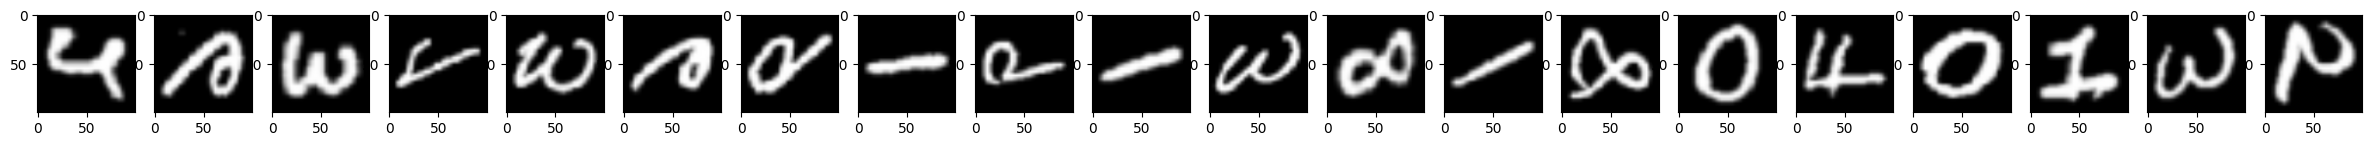

In [71]:
device = "cpu"

data_transforms = transforms.Compose([
    CyclicDeform(epoch= 50, cycle= 120, img_size=(28,28), stretch_intensity=0.2, device=device),
    CycleColor(epoch = 50, cycle= 80, background_tolerance=0.1, device=device, generation_range=10, style_count=500),
    transforms.Resize((100,100), antialias=False)

    # transforms.Normalize(mean=(0.3798, 0.3760, 0.3695) , std=(0.0461, 0.0469, 0.0455)),
])

test_transforms = transforms.Compose([
            ExpandToRGB(),
            transforms.Resize((100,100), antialias=False),

])

train_data = [CudaDataset(_set["train"], device=device) for _set in t[1:]]
print(len(train_data))
aug_set = AugSet(DultiConcatDataset(train_data, device=device), test_transforms)
samp = BatchSampler(RandomSampler(aug_set), 5000, drop_last=False)
# aug_loader =  DataLoader(au

fig, axs = plt.subplots(1,20, figsize=(30,10))

print(len(aug_set))
for batch_num, idx in enumerate(samp):
    xs,ys=aug_set[idx]
    # print(xs.shape)
    x=xs[5]
    pic = x.to("cpu").permute(1, 2, 0).numpy()
    normalized = (pic - np.min(pic))/np.ptp(pic)

    axs[batch_num].imshow(pic)

# plt.imshow(x.transpose(1,2,0))
    

In [57]:
x.shape

torch.Size([3, 100, 100])

In [76]:
x.min()

tensor(0.)

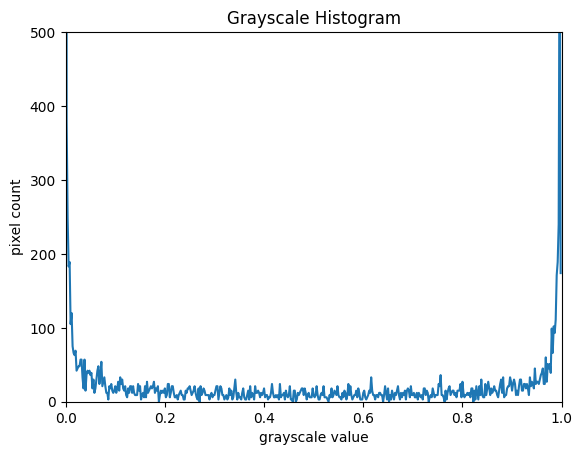

In [74]:
upper_lim = 1
lower_lim = 0

hist, edges = np.histogram(x, bins=500, range=(lower_lim,upper_lim))

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([lower_lim, upper_lim])  # <- named arguments do not work here
plt.ylim((0,500))

plt.plot(edges[0:-1], hist)

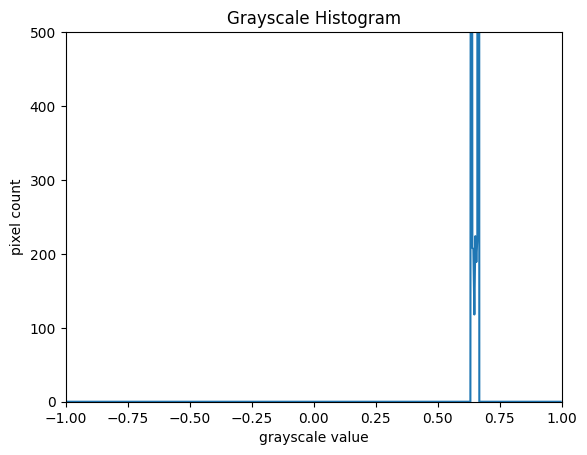

In [67]:
upper_lim = 1
lower_lim = -1

hist, edges = np.histogram(x[2], bins=500, range=(lower_lim,upper_lim))

plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([lower_lim, upper_lim])  # <- named arguments do not work here
plt.ylim((0,500))

plt.plot(edges[0:-1], hist)

In [37]:
hist.shape

(256,)

In [39]:
edges.shape

(257,)

In [14]:
device = "cuda:0"
train_data = [CudaDataset(_set["train"], device=device) for _set in t[1:]]

cycle_length = 10
mean=0
std=0
nb_samples=0

for cycle in range(0,cycle_length):
    data_transforms = transforms.Compose([
        CyclicTorchDeform(epoch=cycle, cycle=cycle_length, img_size=(28,28), stretch_intensity=0.2, device=device, control_points=(2,2)),
        # transforms.Normalize(mean= 0, std=1),
        CycleColor(epoch =cycle, cycle=cycle_length, tolerance=0.1, device=device),
        transforms.Normalize(mean=(0.3798, 0.3760, 0.3695) , std=(0.0461, 0.0469, 0.0455))
        # transforms.ToTensor()
    ])
    aug_set = AugSet(DultiConcatDataset(train_data, device), data_transforms)
    data,targets = aug_set[:]
    size = data.size(0)
    view = data.view(size, data.size(1), -1)
    current_mean = view.mean(2).sum(0)
    mean += current_mean
    current_std = view.std(2).sum(0)
    std += current_std
    print(view.std(2).shape, current_std, current_std/size, current_mean/size)
    nb_samples += size
    del aug_set, view, targets, data
    torch.cuda.empty_cache()

torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([ 2.6074, -2.6866, -2.6264], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([-2.8156, -1.4601,  2.8681], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([-0.3201,  2.6439, -2.6264], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([ 2.6074, -2.6866,  1.1663], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([-2.8156,  2.2194,  2.8681], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.], device='cuda:0') tensor([ 2.6074,  1.8420, -2.6264], device='cuda:0')
torch.Size([201600, 3]) tensor([0., 0., 0.], device='cuda:0') tensor([0., 0., 0.],

In [261]:
tensor_pic = t[0]["train"][0][3]
numpy_pic = tensor_pic.permute(1, 2, 0).numpy()

IndexError: tuple index out of range

In [235]:
def color_and_normalize(pic, background_hue, digit_hue, intensity_tolerance):
    background_mask = (pic < pic.min()+intensity_tolerance) & (pic > pic.min()-intensity_tolerance)
    digit_mask = ~background_mask#(pic < pic.max()+range) & (pic > pic.max()-range)
    normalized = (pic - np.min(pic))/np.ptp(pic)
    color_pic = np.concatenate((normalized,)*3, axis=2)

    color_pic[background_mask.squeeze(), :]  = colorsys.hsv_to_rgb(math.radians(background_hue), 0.5, 0.5)
    color_pic[digit_mask.squeeze(), :]  = colorsys.hsv_to_rgb(math.radians(digit_hue), 0.5, 0.5)
    return color_pic

def cyclic_deform(sample, epoch, cycle, control_points, img_size, axs=None, axs_index=None):
    device="cpu"
    stretch_intensity = 0.35
    angle = (epoch*360/cycle)%360
    angle = (epoch*360/cycle)%360

    x = torch.zeros(size=control_points)
    y = torch.zeros(size=control_points)


    for row in range(control_points[0]):
        for col in range(control_points[1]):
            x[col,row] = math.sin(math.radians(angle))
            y[col,row] = math.cos(math.radians(angle))
            angle += 45

    # print(x)

    displacement_grid = np.mgrid[-1:1:img_size[0]*1j, -1:1:img_size[1]*1j]
    old_x = x[0,0].numpy()
    old_y = y[0,0].numpy()
    x = x.unsqueeze(0).unsqueeze(0)
    y = y.unsqueeze(0).unsqueeze(0)
    # print(x)


    x_displacement = Fun.interpolate(torch.as_tensor(x), img_size, mode="bicubic", align_corners=False)
    y_displacement = Fun.interpolate(torch.as_tensor(y), img_size, mode="bicubic", align_corners=False)
    # y_displacement = Fun.interpolate(, img_size, mode="bicubic", align_corners=False)



    displacement_weights = np.abs(old_x*-displacement_grid[0]-(-displacement_grid[1])*(old_y))/np.linalg.norm((old_x,old_y))
    displacement_weights -= 1
    displacement_weights = np.abs(displacement_weights)
    displacement_weights /= displacement_weights.max()
    displacement_weights = np.around(displacement_weights, 2)
    # z_displacement = np.full((control_points[0],control_points[1]), 1)
    old_displacement = torch.from_numpy(np.asarray((old_x*displacement_weights, old_y*displacement_weights))* stretch_intensity)

    # print(x_displacement.shape)
    displacement = torch.concat((x_displacement, y_displacement), axis=1)* stretch_intensity
    # print(displacement.shape)
    displacement = torch.unsqueeze(displacement[0].permute((1,2,0)), 0).to(device)
    # displacement = torch.unsqueeze(displacement.permute((1,2,0)), 0)



    deformed = F.elastic_transform(sample, displacement, )

    if(axs is not None and axs_index is not None):
        if(axs[0, axs_index] is not None):
            ax = axs[0, axs_index]
          
                    # ax.axline((x_center,y_center), (x_center+x[0,0,row,col],y_center+y[0,0,row,col]), color="white", x_max=x_center+7, y_max=y_center+7)

            base_indices = np.arange(0, 28, 1)
            l1 = np.stack((base_indices, np.full((28), 7)))
            deformed_l1 = l1-displacement[0,l1[0],l1[1]].numpy().T*14
            l2 = np.stack((base_indices, np.full((28), 21)))
            deformed_l2 = l2-displacement[0,l2[0],l2[1]].numpy().T*14
            
            l3 = np.stack((np.full((28), 7), base_indices))
            deformed_l3 = l3-displacement[0,l3[0],l3[1]].numpy().T*14
            l4 = np.stack((np.full((28), 21), base_indices))
            deformed_l4 = l4-displacement[0,l3[0],l3[1]].numpy().T*14


            ax.plot(l1[0], deformed_l1[1], color="white")
            ax.plot(l2[0], deformed_l2[1], color="white")
            ax.plot(deformed_l3[0], l3[1], color="white")
            ax.plot(deformed_l4[0], l4[1], color="white")

        if(axs[1, axs_index] is not None):
            ax = axs[1, axs_index]
            for row in range(control_points[0]):
                for col in range(control_points[1]):
                    center_indices = np.linspace(-7,7,14)
                    y_values = center_indices * y[0,0,col,row].numpy()
                    y_values += 7+14*(col)
                    x_values = center_indices * x[0,0,col,row].numpy() + 7+14*(row)
                    ax.plot(x_values, y_values, color="white")
            ax.imshow(deformed.permute((1,2,0)).numpy(), cmap="gray")

        if(axs[2, axs_index] is not None):
            ax = axs[2, axs_index]
            ax.imshow(np.abs(displacement[0,:,:,0]), vmax=stretch_intensity, vmin=0)

        if(axs[3, axs_index] is not None):
            ax = axs[3, axs_index]
            ax.imshow(np.abs(displacement[0,:,:,1]), vmax=stretch_intensity, vmin=0)

    return deformed.permute((1,2,0)).numpy()


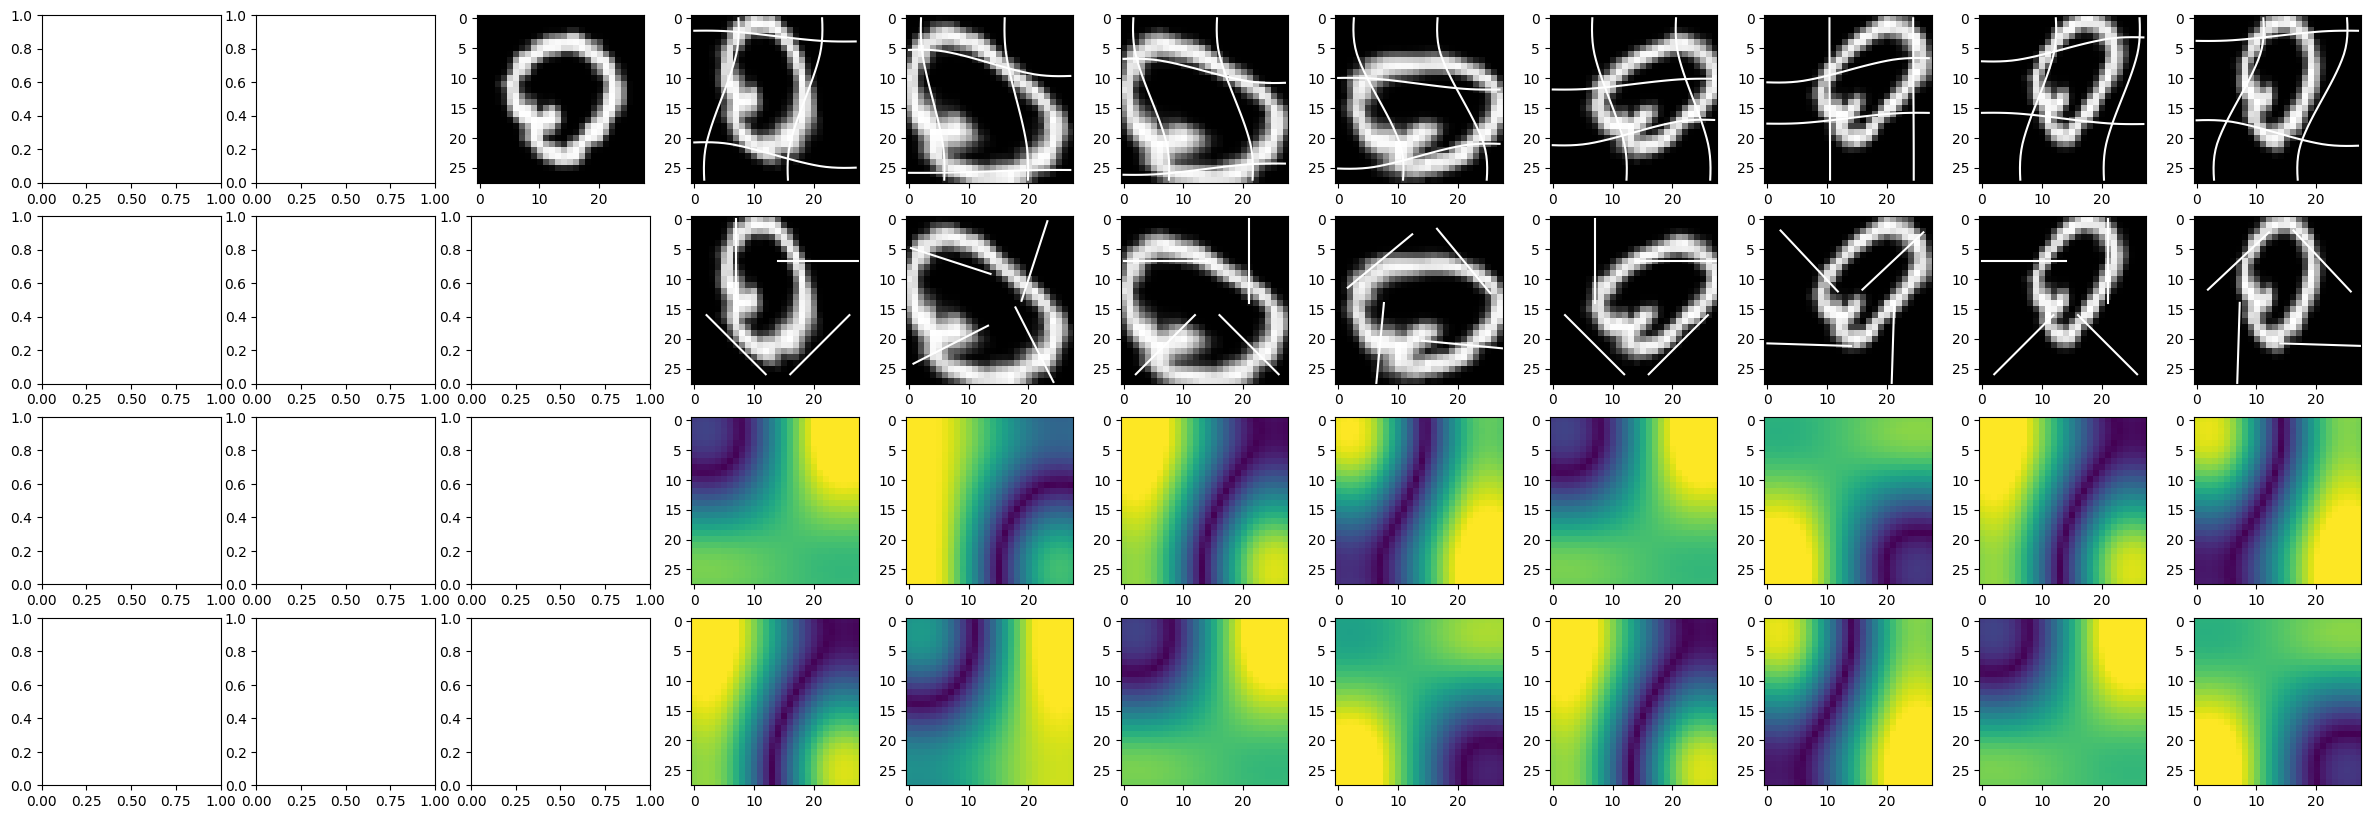

In [236]:
out_pic = tensor_pic
# mask = out_pic == out_pic.min()
# out_pic[mask] = out_pic.max()

pic_size = (28,28)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
deform_grid_shape = (2,2)

intensity_tolerance = 500
line, axs = plt.subplots(4,11, figsize=(30,10))
# axs[0, 0].imshow(color_and_normalize(out_pic, 50, 300, intensity_tolerance))
# axs[0, 1].imshow(color_and_normalize(out_pic, 0, 120, intensity_tolerance))
# axs[2].imshow(color_and_normalize(out_pic, 180, 270, intensity_tolerance))
axs[0, 2].imshow(out_pic.permute((1,2,0)).numpy(), cmap="gray")
axs[0, 3].imshow(cyclic_deform(out_pic, 0, 100, deform_grid_shape, pic_size, axs, 3), cmap="gray")
axs[0, 4].imshow(cyclic_deform(out_pic, 20, 100, deform_grid_shape, pic_size, axs, 4), cmap="gray")
axs[0, 5].imshow(cyclic_deform(out_pic, 25, 100, deform_grid_shape, pic_size, axs, 5), cmap="gray")
axs[0, 6].imshow(cyclic_deform(out_pic, 36, 100, deform_grid_shape, pic_size, axs, 6), cmap="gray")
axs[0, 7].imshow(cyclic_deform(out_pic, 50, 100, deform_grid_shape, pic_size, axs, 7), cmap="gray")
axs[0, 8].imshow(cyclic_deform(out_pic, 62, 100, deform_grid_shape, pic_size, axs, 8), cmap="gray")
axs[0, 9].imshow(cyclic_deform(out_pic, 75, 100, deform_grid_shape, pic_size, axs, 9), cmap="gray")
axs[0, 10].imshow(cyclic_deform(out_pic, 87, 100, deform_grid_shape, pic_size, axs, 10), cmap="gray")

# Tuning

In [1]:
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim

optim = optim.AdamW
sched = lr_scheduler.LinearLR(None)

TypeError: NoneType is not an Optimizer